<a href="https://colab.research.google.com/github/ecastanedat/579-Intelligent-Systems-Term-Project/blob/Dev-001-AI-model/04_Tests%5CModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FER Model with FER2013

### Importing necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
import tensorflow as tf

### Download Data

This section of the code creates the folder structure in the Colab environment, to download the dataset file from Google Drive to the specified location in Colab.

In [ ]:
# Ensure the /content/dataset folder exists
import os
if not os.path.exists('/content/dataset'):
    os.makedirs('/content/dataset')


!pip install gdown
import gdown

url = 'https://drive.google.com/uc?id=19E8zehTCTXxDDr4XiwluWE5PDPlten25'
output = '/content/dataset/train.csv'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=19E8zehTCTXxDDr4XiwluWE5PDPlten25
To: /content/dataset/train.csv
100%|██████████| 241M/241M [00:04<00:00, 58.2MB/s]


'/content/dataset/train.csv'

### Load Data

This code reads training data from a CSV file, processes the data, and stores it as NumPy arrays for further use. The code reads image data and labels from the CSV file, processes them into NumPy arrays, and stores them as x_training and y_training for further use in the training process for model

In [ ]:
training_images = []
training_labels = []
categories_count = {}

with open('/content/dataset/train.csv') as train_file:
    csv_file_reader = csv.reader(train_file)
    next(csv_file_reader)  # Skip the header

    for row in csv_file_reader:
        # Parse image pixels and reshape it
        pixels_str = row[1]
        pixels_list = np.array(list(map(int, pixels_str.split(' '))), dtype='uint8')
        image = pixels_list.reshape((48, 48))
        training_images.append(image)

        # Count label occurrences
        label_str = row[0]
        categories_count[label_str] = categories_count.get(label_str, 0) + 1

        # Append label
        label = int(label_str)
        training_labels.append(label)

# Convert lists to numpy arrays
x_training = np.array(training_images)
y_training = np.array(training_labels)

print('x_training shape:', x_training.shape)
print('y_training shape:', y_training.shape)

x_training shape: (28709, 48, 48)
y_training shape: (28709,)


### Visualize Data

The image dataset provided by Kaggle contains 7 different facial expression categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The code is generating a histogram to visualize the count of each emotion category in the FER2013 dataset.

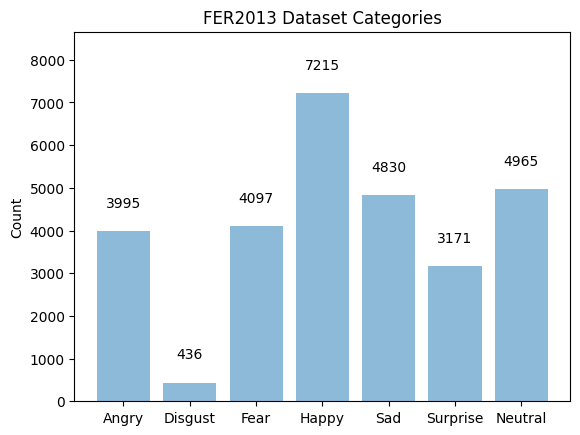

In [ ]:
categories = ('Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral')
y_pos = np.arange(len(categories))

counts = [categories_count[str(label)] for label in range(len(categories))]

# Draw histogram
fig, ax = plt.subplots()
bars = ax.bar(y_pos, counts, align='center', alpha=0.5)
ax.set_xticks(y_pos)
ax.set_xticklabels(categories)
ax.set_ylabel('Count')
ax.set_title('FER2013 Dataset Categories')

# Add text labels above each bar
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax.annotate(f'{count}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 15),
                textcoords="offset points", ha='center', va='bottom', fontsize=10)

y_max = max(counts)
ax.set_ylim(0, y_max * 1.2)

plt.show()

### Preprocess Data

Here we split the dataset into training set and test set using the function from scikit-learn. We choose 20% of the dataset for testing, and the rest of the dataset for training.

In [ ]:
# Split dataset into train set and test set
image_train, image_test, labels_train, labels_test = train_test_split(x_training, y_training, test_size=0.2)

# Normalize the pixel values to range between 0 and 1
x_train = image_train / 255.0
x_test  = image_test  / 255.0

# Reshape the input data to match the expected shape by the model
x_train = x_train.reshape(len(x_train), 48, 48, 1)
x_test = x_test.reshape(len(x_test), 48, 48, 1)

print(x_train.shape)
print(x_test.shape)

(22967, 48, 48, 1)
(5742, 48, 48, 1)


### Train Model

This part of the code sets up the environment for TensorFlow 2.x, imports various components from TensorFlow's Keras API, including layers, optimizers, callbacks, and an image data generator, and it prints the version of TensorFlow being used.

In [ ]:
print('Tensorflow version: {}'.format(tf.__version__))

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras import Model, Input

from tensorflow.keras.preprocessing.image import ImageDataGenerator


Tensorflow version: 2.12.0


### Model Architecture

This part of the code defines a convolutional neural network (CNN) model for the Facial Expression Recognition (FER) task. Here's a summary of what the code is doing:

1. Define the input shape of the images to be (48, 48, 1). These are grayscale images with a size of 48x48 pixels.

2. Create an input layer using the Input function with the specified input shape.

3. Define the first convolution block:

- Apply a 2D convolution layer with 64 filters, a kernel size of (3, 3), ReLU activation, and padding 'same' to preserve spatial dimensions.
- Add a Batch Normalization layer after the convolution.
- Apply another 2D convolution layer with the same settings.
- Add another Batch Normalization layer.
- Apply MaxPooling with a pool size of (3, 3) and strides of (2, 2).
- Add a Dropout layer with a rate of 0.3 to randomly deactivate neurons during training.

4. Define the second convolution block with similar layers as in the first block but with 128 filters.

5. Define the third convolution block with similar layers as in the first two blocks but with 256 filters.

6. Add fully connected layers after the convolution blocks:

- Flatten the output to convert it to a 1D vector.
- Apply a Dense layer with 512 units and ReLU activation.
- Add a Dropout layer with a rate of 0.3.
- Apply another Dense layer with 256 units and ReLU activation.
- Add another Dropout layer with a rate of 0.3.
- Apply a final Dense layer with 64 units and ReLU activation.
- Add a Dropout layer with a rate of 0.3.

7. Define the output layer with a Dense layer having 7 units and a softmax activation function. This layer represents the probabilities for the 7 facial expression classes.

8. Create the FER_model using the Model function with the specified input and output layers.

9. Compile the model with the Adam optimizer, a learning rate of 0.001, and using 'sparse_categorical_crossentropy' as the loss function (suitable for integer labels).

10. Print a summary of the model architecture showing the number of parameters and the flow of data through each layer.

In [ ]:
# Define input shape
input_shape = (48, 48, 1)

# Input layer
input_layer = Input(shape=input_shape)

# 1st convolution block
x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(input_layer)
x = BatchNormalization()(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(3, 3), strides=(2, 2))(x)
x = Dropout(0.3)(x)

# 2nd convolution block
x = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(3, 3), strides=(2, 2))(x)
x = Dropout(0.3)(x)

# 3rd convolution block
x = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(3, 3), strides=(2, 2))(x)
x = Dropout(0.3)(x)

# Fully connected layers
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)

# Output layer
output_layer = Dense(7, activation='softmax')(x)

# Create the model
FER_model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
adam = Adam(learning_rate=0.001)
FER_model.compile(optimizer=adam,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Summary the model
FER_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0     

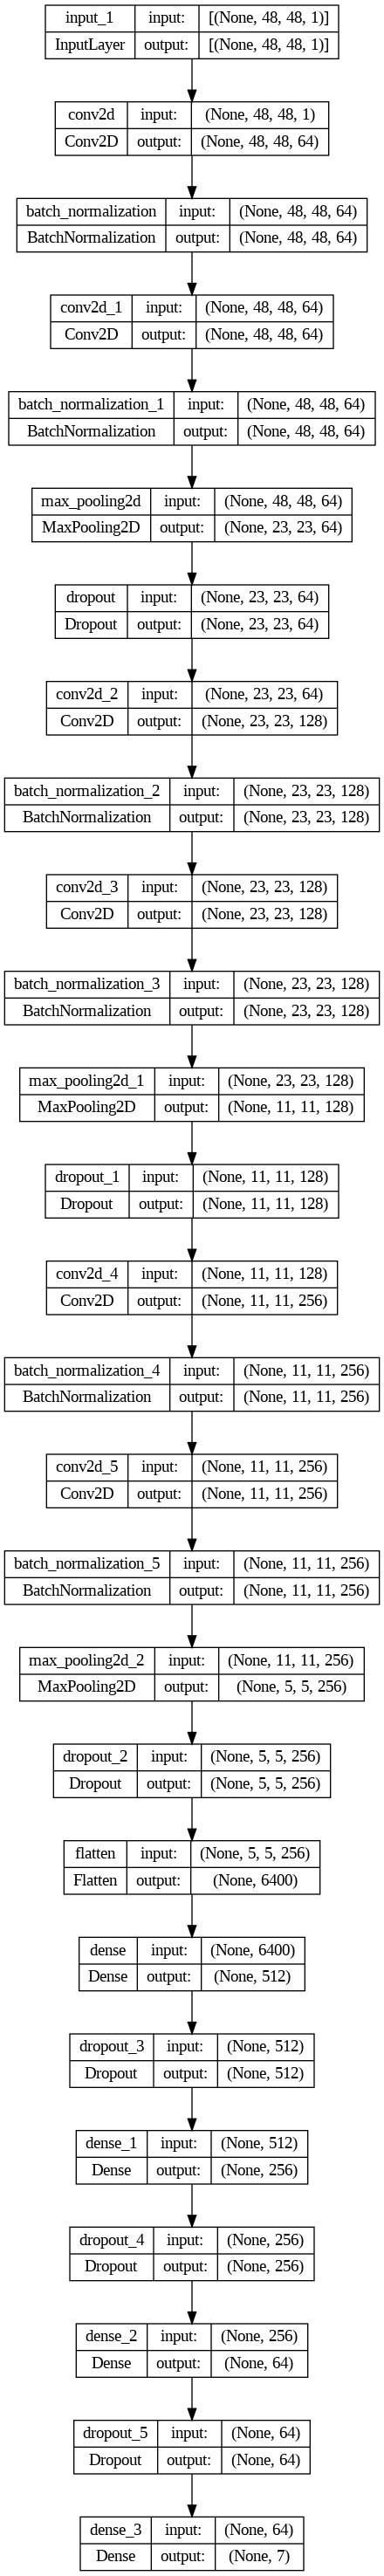

In [ ]:
plot_model(FER_model, to_file='model.png', show_shapes=True, show_layer_names=True)

This part of the code is responsible for training the model using the provided training data (x_train, labels_train) and validation data (x_test, labels_test), and it also includes some callbacks to help manage the training process.

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)
reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5)

# Train the model
history = FER_model.fit(x_train,
                        labels_train,
                        batch_size=64,
                        epochs=100,
                        validation_data=(x_test, labels_test),
                        callbacks=[early_stopping, reduce_learning_rate])

Epoch 1/100
359/359 [==============================] - 23s 19ms/step - loss: 2.0184 - accuracy: 0.2262 - val_loss: 1.8129 - val_accuracy: 0.2520 - lr: 0.0010
Epoch 2/100
359/359 [==============================] - 6s 17ms/step - loss: 1.7063 - accuracy: 0.2993 - val_loss: 1.5980 - val_accuracy: 0.3191 - lr: 0.0010
Epoch 4/100
359/359 [==============================] - 6s 17ms/step - loss: 1.6101 - accuracy: 0.3405 - val_loss: 1.4996 - val_accuracy: 0.3924 - lr: 0.0010
Epoch 5/100
359/359 [==============================] - 6s 17ms/step - loss: 1.5280 - accuracy: 0.3829 - val_loss: 1.4874 - val_accuracy: 0.3710 - lr: 0.0010
Epoch 6/100
359/359 [==============================] - 6s 17ms/step - loss: 1.4488 - accuracy: 0.4154 - val_loss: 1.3519 - val_accuracy: 0.4350 - lr: 0.0010
Epoch 7/100
359/359 [==============================] - 6s 17ms/step - loss: 1.4015 - accuracy: 0.4456 - val_loss: 1.3697 - val_accuracy: 0.4805 - lr: 0.0010
Epoch 8/100
359/359 [==============================] - 6s

After the training process is completed, let's display the accuracy diagram of the training accuracy and validation accuracy.

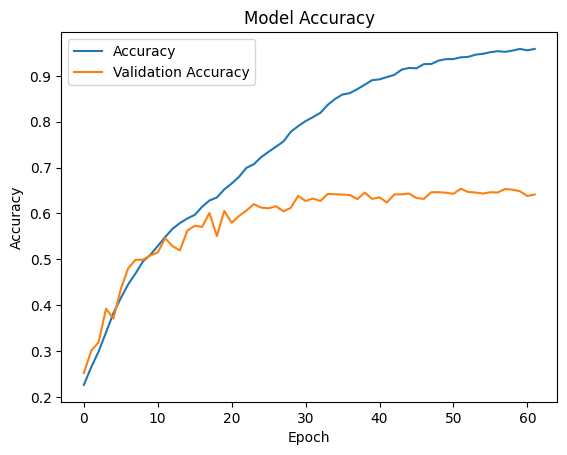

In [ ]:
# Show accuracy diagram
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Validation Accuracy'])
plt.show()

In [ ]:
# Evaluate the accuracy of the model
_, score_before_improvement = FER_model.evaluate(x_test, labels_test)
print('Score before improvement: {}'.format(score_before_improvement))

180/180 [==============================] - 1s 4ms/step - loss: 2.0578 - accuracy: 0.6414
Score before improvement: 0.6414141654968262


### Improve Model

We will next enhance our model by creating a set of hard data. Rather than repeatedly training the model on the same examples, we will identify the images that the model mislabels and specifically focus our training on these challenging instances. To do this, we'll first use our model to make predictions and then collect the incorrectly predicted images into a hard data array for subsequent training.

In [ ]:
from pandas._libs.tslibs.dtypes import FreqGroup
# Generate hard data
hard_images = []
hard_labels = []

# Make predictions
predictions = FER_model.predict(x_test)
for i, v in enumerate(predictions):
    y_predict = np.argmax(v)
    y_real = labels_train[i]
    if y_predict != y_real:
        # If predict incorrectly, append to array
        image = x_train[i]
        hard_image = image.reshape(1, 48, 48, 1)
        hard_images.append(image)
        hard_labels.append(y_real)

x_hard = np.array(hard_images)
y_hard = np.array(hard_labels)

print(x_hard.shape)
print(y_hard.shape)

180/180 [==============================] - 1s 2ms/step
(4710, 48, 48, 1)
(4710,)


Next, we will train our model on these specific images which are previously incorrectly labelled by our model.

In [ ]:
# Train the model on hard data
x_hard_train, x_hard_test, y_hard_train, y_hard_test = train_test_split(x_hard, y_hard, test_size=0.2)
history = FER_model.fit(x_hard_train,
                        y_hard_train,
                        batch_size=64,
                        epochs=100,
                        validation_data=(x_hard_test, y_hard_test),
                        callbacks=[early_stopping, reduce_learning_rate])

Epoch 1/100
59/59 [==============================] - 1s 24ms/step - loss: 0.1488 - accuracy: 0.9544 - val_loss: 0.0193 - val_accuracy: 0.9936 - lr: 4.7830e-04
Epoch 2/100
59/59 [==============================] - 1s 18ms/step - loss: 0.1241 - accuracy: 0.9620 - val_loss: 0.0181 - val_accuracy: 0.9958 - lr: 4.7830e-04
Epoch 3/100
59/59 [==============================] - 1s 18ms/step - loss: 0.1055 - accuracy: 0.9700 - val_loss: 0.0202 - val_accuracy: 0.9947 - lr: 4.7830e-04
Epoch 4/100
59/59 [==============================] - 1s 18ms/step - loss: 0.0922 - accuracy: 0.9711 - val_loss: 0.0219 - val_accuracy: 0.9915 - lr: 4.7830e-04
Epoch 5/100
59/59 [==============================] - 1s 18ms/step - loss: 0.0831 - accuracy: 0.9766 - val_loss: 0.0237 - val_accuracy: 0.9926 - lr: 4.7830e-04
Epoch 6/100
59/59 [==============================] - 1s 18ms/step - loss: 0.0880 - accuracy: 0.9761 - val_loss: 0.0237 - val_accuracy: 0.9936 - lr: 4.7830e-04
Epoch 7/100
59/59 [===========================

Training the same model (FER_model) again. By calling the fit method on the same model object, we are continuing the training process with the augmented data generated by ImageDataGenerator.

The model's existing weights will be used as the starting point for this new phase of training. The augmented data adds new variations to the training dataset, allowing the model to learn additional features and further refine its understanding of the underlying patterns in the data. This continued training on augmented data can enhance the model's ability to generalize to unseen examples and can lead to improved performance on validation and test sets.

In [ ]:
# Perform data augmentation
data_generator = ImageDataGenerator(featurewise_center=False,
                                    featurewise_std_normalization=False,
                                    rotation_range=10,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=.1,
                                    horizontal_flip=True)
flow = data_generator.flow(x_train,
                           labels_train,
                           batch_size=64)

# Train the model again to balance out
history = FER_model.fit(flow,
                        epochs=100,
                        validation_data=(x_test, labels_test),
                        callbacks=[early_stopping, reduce_learning_rate])

Epoch 1/100
359/359 [==============================] - 11s 28ms/step - loss: 1.1531 - accuracy: 0.6145 - val_loss: 1.0007 - val_accuracy: 0.6419 - lr: 3.8742e-04
Epoch 2/100
359/359 [==============================] - 10s 28ms/step - loss: 1.0533 - accuracy: 0.6353 - val_loss: 0.9805 - val_accuracy: 0.6587 - lr: 3.8742e-04
Epoch 3/100
359/359 [==============================] - 10s 28ms/step - loss: 1.0165 - accuracy: 0.6464 - val_loss: 0.9675 - val_accuracy: 0.6520 - lr: 3.8742e-04
Epoch 4/100
359/359 [==============================] - 10s 28ms/step - loss: 0.9877 - accuracy: 0.6555 - val_loss: 0.9683 - val_accuracy: 0.6473 - lr: 3.8742e-04
Epoch 5/100
359/359 [==============================] - 10s 28ms/step - loss: 0.9850 - accuracy: 0.6564 - val_loss: 0.9578 - val_accuracy: 0.6545 - lr: 3.8742e-04
Epoch 6/100
359/359 [==============================] - 10s 28ms/step - loss: 0.9718 - accuracy: 0.6625 - val_loss: 0.9491 - val_accuracy: 0.6637 - lr: 3.8742e-04
Epoch 7/100
359/359 [=======

Finally, let's evaluate our model again after improvement. Previously, we have the validation accuracy at around 64%. Nevertheless, the validation accuracy has increased to around **67%**.

In [ ]:
# Evaluate the model after improvement
_, score_after_improvement = FER_model.evaluate(x_test, labels_test)
print('Score after improvement: {}'.format(score_after_improvement))

180/180 [==============================] - 1s 3ms/step - loss: 0.9489 - accuracy: 0.6721
Score after improvement: 0.6720654964447021


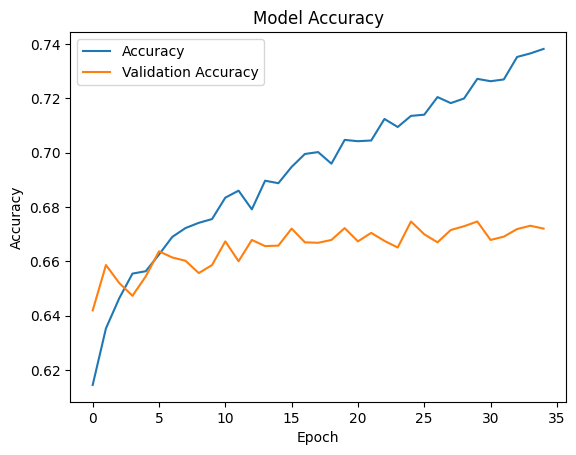

In [ ]:
# Show accuracy diagram
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Validation Accuracy'])
plt.show()

### Confusion Matrix

Use a confusion matrix to see how well the model performs for each category of facial expression.

180/180 [==============================] - 0s 2ms/step


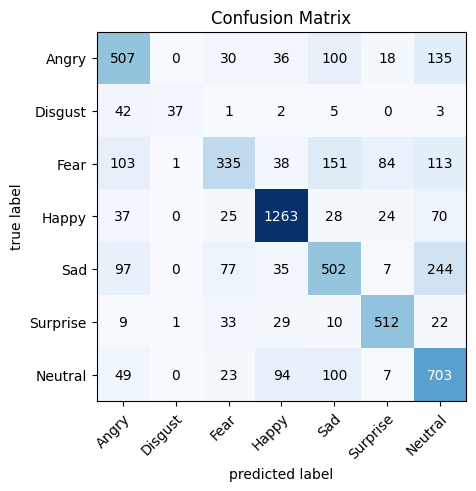

In [ ]:
!pip install -U mlxtend > /dev/null 2>&1

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# Make predictions
predictions = FER_model.predict(x_test)
y_predict = np.argmax(predictions, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(labels_test, y_predict)

# Display confusion matrix
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, class_names=class_names)
plt.title('Confusion Matrix')
plt.show()

### Export Model

Export the model, and save our TensorFlow model.

In [ ]:
# Ensure the /content/dataset folder exists
import os
if not os.path.exists('/content/model'):
    os.makedirs('/content/model')
# Save tensorflow model
FER_model.save('/content/model/modelv10.h5')

## Conclusion

This code defines a process for building and training a convolutional neural network (CNN) model for facial expression recognition (FER) using the FER2013 dataset. This code represents a custom architecture with elements that are reminiscent of both VGG and ResNet but doesn't strictly adhere to either.